In [1]:
import os
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
from mpmath import mp, nstr
%matplotlib inline

if '/Users/daniele/Postdoc/Research/CA3/entropy' not in sys.path:
    sys.path.append('/Users/daniele/Postdoc/Research/CA3/entropy')
import ctw
from utils import binarize

In [2]:
def despine(ax, sides=('right','top')):
    for side in sides:
        ax.spines[side].set_visible(False)

In [3]:
def rasterplot(spikes, tend=np.inf, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    for i,train in enumerate(spikes):
        x = train[train < tend]
        y = i + 1 + np.zeros(x.size)
        ax.plot(x, y, '.', **kwargs)

In [12]:
def plot_data_file(data_file, ttran, firing_rate, CV, Hx, MI, ax=None):
    
    data = np.load(data_file, allow_pickle=True)
    
    config = data['config'][()]
    delay = config['sim']['delay']
    dur = config['sim']['stim_dur']
    t0, t1 = delay + ttran, delay + dur
    bursts_rate = config['synaptic_activation_frequency']
    
    if bursts_rate > 0:
        presyn_spike_times = data['presyn_spike_times']
        presyn_burst_times = np.tile(data['presyn_burst_times'][np.newaxis, :], \
                                     [presyn_spike_times.shape[0], 1])
        presyn_spike_times = (presyn_spike_times - presyn_burst_times).T
        presyn_idx = np.argsort(presyn_spike_times.max(axis=1))
        presyn_spike_times = presyn_spike_times[presyn_idx,:]

        n_rows = 3
    else:
        n_rows = 1

    ms = 2

    bin_size = 1000. / bursts_rate if bursts_rate > 0 else 500.
    spike_times = data['spike_times']
    bins = np.arange(0, np.ceil(spike_times[-1]) + bin_size/2, bin_size)
    n,_ = np.histogram(spike_times, bins)
    spks = []
    idx = np.concatenate([[0], np.cumsum(n)])
    for j in range(1, len(idx)):
        spks.append(spike_times[idx[j-1]:idx[j]] - (j - 1) * bin_size)

    retvals = [spks.copy()]
    spks = spks[:200]
    if ax is None:
        fig,ax = plt.subplots(n_rows, 1, figsize=(5, 2.5 * n_rows))
        if n_rows == 1:
            ax = [ax]
    else:
        fig = None
    rasterplot(spks, color='k', markersize=ms, ax=ax[0])
    ax[0].set_yticks([1, len(spks)])
    ax[0].set_ylabel('Trial #')
    if n_rows == 1:
        ax[0].set_xlabel('Time (ms)')

    if bursts_rate > 0:
        burst_times = data['presyn_burst_times']
        spks = []
        window = 100
        for burst_time in burst_times:
            jdx = (spike_times > burst_time) & (spike_times < burst_time + window)
            spks.append(spike_times[jdx] - burst_time)
        spks = [spks[pre_idx] for pre_idx in presyn_idx]
        retvals.append(spks.copy())
        rasterplot(spks[:500], color='k', markersize=ms, ax=ax[1])
        ax[1].set_yticks([1, np.min([len(spks),500])])
        ax[1].set_xlim([0, window])
        ax[1].set_ylabel('Presynaptic burst #')

        if len(ax) > 2:
            rasterplot(presyn_spike_times, color='k', markersize=ms, ax=ax[2])
            ax[2].set_yticks([1, len(spks)])
            ax[2].set_xlim([0, window])
            ax[2].set_ylabel('Presynaptic burst #')
        ax[-1].set_xlabel('Time (ms)')

        bin_size = 5
        n_bins = window // bin_size + 1
        n,edges = np.histogram(np.sort(np.concatenate(spks)), bins=n_bins, range=(0, window))
        color = 'm'
        X = np.zeros((2, n_bins))
        X[0,:] = edges[:-1] + bin_size / 2
        X[1,:] = n / (len(spks) * bin_size * 1e-3)
        retvals.append(X)
        ax_rate = ax[1].twinx()
        ax_rate.plot(X[0,:], X[1,:], color=color, lw=2)
        ax_rate.set_ylabel('Firing rate (spike/s)', color=color)
        ax_rate.tick_params(axis='y', labelcolor=color)
        ax_rate.set_ylim([0,50])
        ax_rate.spines['top'].set_visible(False)
        #ax[0].set_title(f'F={firing_rate:.1f} AP/s CV={CV:.2f} H={nstr(Hx)} bits/s MI={nstr(MI)} bits/s')
    #else:
        #ax[0].set_title(f'F={firing_rate:.1f} AP/s CV={CV:.2f} H={nstr(Hx)} bits/s')

    for a in ax:
        despine(a)

    if fig is not None:
        fig.tight_layout()
        outfile = os.path.splitext(data_file)[0] + '_summary.pdf'
        fig.savefig(outfile)
        
    return tuple(retvals)

In [5]:
def process_data_files(data_files, ttran, bin_size, ctw_depth, presyn_spike_train_idx=None, verbose=False):
    n_files = len(data_files)
    data = [np.load(data_file, allow_pickle=True) for data_file in data_files]
    config = data[0]['config'][()]
    delay = config['sim']['delay']
    dur = config['sim']['stim_dur']
    t0, t1 = delay + ttran, delay + dur
    bursts_rate = config['synaptic_activation_frequency']

    spike_times = []
    pre_spks = []
    ISI = []
    for i in range(n_files):
        spks = data[i]['spike_times'] # [ms]
        ISI.append(np.diff(spks)) # [ms]
        spks = spks[(spks > t0) & (spks < t1)] - t0 + i * (t1 - t0)
        spike_times.append(spks) # [ms]
        if bursts_rate > 0:
            n_spines = len(data[i]['presyn_spike_times'])
            
            if presyn_spike_train_idx is not None:
                pre_spks.append([spks[(spks > t0) & (spks < t1)] - t0 + i * (t1 - t0) \
                                for spks in data[i]['presyn_spike_times']]) # [ms]
            else:
                tmp = [spks[(spks > t0) & (spks < t1)] - t0 + i * (t1 - t0) \
                                for spks in data[i]['presyn_spike_times']]
                L = np.min([len(t) for t in tmp])
                pre_spks.append(np.array([t[:L] for t in tmp]).min(axis=0))
    tend = (t1 - t0) * n_files * 1e-3 # [s]
    spike_times = np.concatenate(spike_times) * 1e-3 # [s]
    ISI = np.concatenate(ISI) * 1e-3 # [s]

    x = binarize(spike_times, bin_size, tend)
    if x.max() > 1:
        raise Exception('x is not binary')

    firing_rate = 1 / ISI.mean()
    CV = ISI.std() / ISI.mean()

    Hx = ctw.compute_entropy(x, ctw_depth, alphabet_length = 2)
    Hx /= bin_size

    # theoretical entropy of a Poisson process
    Hx_theor = firing_rate * mp.log(mp.e / (firing_rate * bin_size), 2)

    if bursts_rate > 0:
        if presyn_spike_train_idx is not None:
            presyn_spike_times = []
            for i in range(n_spines):
                tmp = []
                for j in range(n_files):
                    tmp.append(pre_spks[j][i])
                presyn_spike_times.append(np.concatenate(tmp) * 1e-3) # [s]
            y = np.array([binarize(pre_spikes, bin_size, tend) for pre_spikes in presyn_spike_times])
            if isinstance(presyn_spike_train_idx, int):
                y = y[presyn_spike_train_idx]
            elif isinstance(presyn_spike_train_idx, slice):
                y = y[presyn_spike_train_idx].sum(axis=0)
            elif isinstance(presyn_spike_train_idx, str) and presyn_spike_train_idx.lower() == 'all':
                y = y.sum(axis=0)
            else:
                raise Exception('presyn_spike_train_idx must be an integer, a slice or None')
        else:
            presyn_spike_times = np.concatenate(pre_spks) * 1e-3 # [s]
            y = binarize(presyn_spike_times, bin_size, tend)
        for i in range(1, y.max() + 1):
            print(f'There are {np.sum(y == i)} bins with {i} spikes.')
        y[y > 1] = 1
        if y.max() > 1:
            raise Exception('y is not binary')
        Hy = ctw.compute_entropy(y, ctw_depth, alphabet_length = 2)
        Hy /= bin_size
        Hxy = ctw.compute_conditional_entropy(x, y, ctw_depth, alphabet_length = 4)
        Hxy /= bin_size
        MI = Hx - Hxy
        
        ones, = np.where(y == 1)
        idx = np.cumsum(np.random.permutation(np.diff(ones)))
        y_shuffled = np.zeros(y.shape, dtype=np.int8)
        y_shuffled[idx] = 1
        Hy_shuffled = ctw.compute_entropy(y_shuffled, ctw_depth, alphabet_length = 2)
        Hy_shuffled /= bin_size
        Hxy_shuffled = ctw.compute_conditional_entropy(x, y_shuffled, ctw_depth, alphabet_length = 4)
        Hxy_shuffled /= bin_size
        MI_shuffled = Hx - Hxy_shuffled

    else:
        Hy = None
        Hxy = None
        MI = None
        Hy_shuffled = None
        Hxy_shuffled = None
        MI_shuffled = None
    
    if verbose:
        print(f'Firing rate: {firing_rate:.2f} spike/s')
        print(f'CV: {CV:.4f}')
        print(f'Entropy: {nstr(Hx)} bits/sec')
        print(f'Entropy of a Poisson process at the same firing rate: {nstr(Hx_theor)} bits/sec')
        print(f'Ratio: {nstr(Hx / Hx_theor)}')
        if bursts_rate > 0:
            print(f'Entropy of presynaptic spikes: {nstr(Hy)} bits/sec')
            print(f'MI: {nstr(MI)} bits/sec')
            print(f'Entropy of shuffled presynaptic spikes: {nstr(Hy_shuffled)} bits/sec')
            print(f'MI shuffled: {nstr(MI_shuffled)} bits/sec')

    plot_data_file(data_files[0], ttran, firing_rate, CV, Hx, MI)

    return firing_rate, CV, Hx, Hx_theor, Hy, Hxy, MI, Hy_shuffled, Hxy_shuffled, MI_shuffled

In [6]:
base_folder = '/Users/daniele/Postdoc/Research/CA3/OPTIMIZATIONS'
cell_types = 'Thorny', 'A-thorny'
cell_IDs = {'Thorny': 'DH070813', 'A-thorny': 'DH070213C3'}
optimization_runs = {'Thorny': '20191208071008_DH070813_', \
                     'A-thorny': '20191206232623_DH070213C3_'}
expt_folders = {cell_type: base_folder + '/' + cell_type + '/' + cell_IDs[cell_type] + \
                '/' + optimization_runs[cell_type] + '/synaptic_cooperativity_experiment/' \
               for cell_type in cell_types}

In [7]:
BIN_SIZE = 4e-3
ttran = 100
ctw_depth = 10
# presyn_spike_train_idx = 0
# presyn_spike_train_idx = slice(3)
presyn_spike_train_idx = None

There are 3297 bins with 1 spikes.
Firing rate: 3.59 spike/s
CV: 0.6680
Entropy: 26.5307 bits/sec
Entropy of a Poisson process at the same firing rate: 27.1278 bits/sec
Ratio: 0.977989
Entropy of presynaptic spikes: 15.4803 bits/sec
MI: -0.246792 bits/sec
Entropy of shuffled presynaptic spikes: 15.4764 bits/sec
MI shuffled: -0.246783 bits/sec
There are 3207 bins with 1 spikes.
Firing rate: 4.04 spike/s
CV: 1.2529
Entropy: 17.218 bits/sec
Entropy of a Poisson process at the same firing rate: 29.8634 bits/sec
Ratio: 0.576557
Entropy of presynaptic spikes: 15.1306 bits/sec
MI: -0.343986 bits/sec
Entropy of shuffled presynaptic spikes: 15.1267 bits/sec
MI shuffled: -0.351856 bits/sec


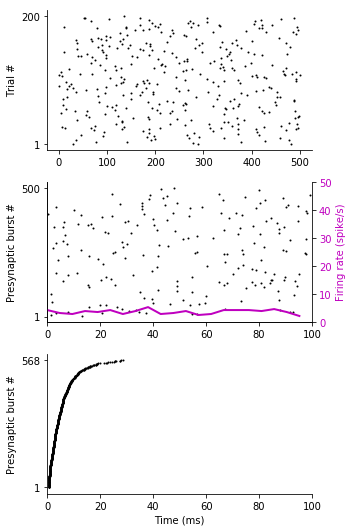

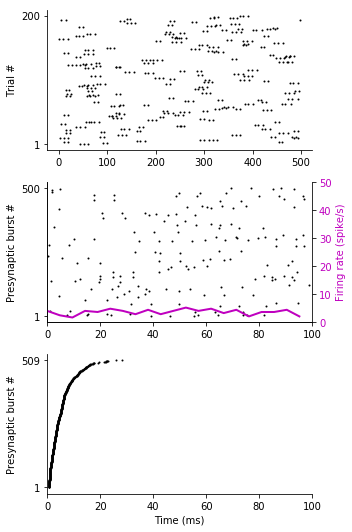

In [8]:
firing_rate_baseline = {}
CV_baseline = {}
Hx_baseline = {}
Hx_theor_baseline = {}
Hy_baseline = {}
Hxy_baseline = {}
MI_baseline = {}
Hy_shuffled_baseline = {}
Hxy_shuffled_baseline = {}
MI_shuffled_baseline = {}
for cell_type in cell_types:
    data_files = glob.glob(expt_folders[cell_type] + 'N=1/synaptic_activation_*.npz')
    firing_rate_baseline[cell_type], CV_baseline[cell_type], Hx_baseline[cell_type], \
    Hx_theor_baseline[cell_type], Hy_baseline[cell_type], Hxy_baseline[cell_type], \
    MI_baseline[cell_type], Hy_shuffled_baseline[cell_type], \
    Hxy_shuffled_baseline[cell_type], MI_shuffled_baseline[cell_type] = \
    process_data_files(data_files, ttran, BIN_SIZE, ctw_depth, presyn_spike_train_idx, verbose=True)

In [9]:
%%capture --no-stdout out

poisson_rate = {}
firing_rate = {}
CV = {}
Hx = {}
Hx_theor = {}
Hy = {}
Hxy = {}
MI = {}
Hy_shuffled = {}
Hxy_shuffled = {}
MI_shuffled = {}
N_spines = 6

for cell_type in cell_types:
    expt_folder = expt_folders[cell_type]
    folders = glob.glob(expt_folder + f'N={N_spines}/F=*')
    poisson_rate[cell_type] = np.array([float(os.path.split(folder)[-1][2:]) for folder in folders])
    idx = np.argsort(poisson_rate[cell_type])
    poisson_rate[cell_type] = poisson_rate[cell_type][idx]
    folders = [folders[i] for i in idx]
    N_folders = len(folders)

    firing_rate[cell_type] = np.zeros(N_folders)
    CV[cell_type] = np.zeros(N_folders)
    Hx[cell_type] = np.zeros(N_folders)
    Hx_theor[cell_type] = np.zeros(N_folders)
    Hy[cell_type] = np.array([np.nan for _ in range(N_folders)])
    Hxy[cell_type] = np.array([np.nan for _ in range(N_folders)])
    MI[cell_type] = np.array([np.nan for _ in range(N_folders)])
    Hy_shuffled[cell_type] = np.array([np.nan for _ in range(N_folders)])
    Hxy_shuffled[cell_type] = np.array([np.nan for _ in range(N_folders)])
    MI_shuffled[cell_type] = np.array([np.nan for _ in range(N_folders)])

    for i,folder in enumerate(folders):
        msg = f'Analyzing data in {os.path.sep.join(folder.split(os.path.sep)[7:])}'
        print('=' * len(msg))
        print(msg)
        data_files = glob.glob(folder + '/synaptic_activation_*.npz')
        firing_rate[cell_type][i], CV[cell_type][i], Hx[cell_type][i], \
        Hx_theor[cell_type][i], Hy[cell_type][i], Hxy[cell_type][i], MI[cell_type][i], \
        Hy_shuffled[cell_type][i], Hxy_shuffled[cell_type][i], MI_shuffled[cell_type][i] = \
        process_data_files(data_files, ttran, BIN_SIZE, ctw_depth, presyn_spike_train_idx, verbose=True)
        
    MI[cell_type][MI[cell_type] < 0] = 0
    MI_shuffled[cell_type][MI_shuffled[cell_type] < 0] = 0

Analyzing data in Thorny/DH070813/20191208071008_DH070813_/synaptic_cooperativity_experiment/N=6/F=0
Firing rate: 3.57 spike/s
CV: 0.6705
Entropy: 26.4393 bits/sec
Entropy of a Poisson process at the same firing rate: 27.0184 bits/sec
Ratio: 0.978567
Analyzing data in Thorny/DH070813/20191208071008_DH070813_/synaptic_cooperativity_experiment/N=6/F=50
There are 6637 bins with 1 spikes.
Firing rate: 3.82 spike/s
CV: 0.6898
Entropy: 28.0238 bits/sec
Entropy of a Poisson process at the same firing rate: 28.5377 bits/sec
Ratio: 0.981993
Entropy of presynaptic spikes: 15.6011 bits/sec
MI: -0.0701667 bits/sec
Entropy of shuffled presynaptic spikes: 15.5992 bits/sec
MI shuffled: -0.139896 bits/sec
Analyzing data in Thorny/DH070813/20191208071008_DH070813_/synaptic_cooperativity_experiment/N=6/F=100
There are 3129 bins with 1 spikes.
Firing rate: 4.10 spike/s
CV: 0.6950
Entropy: 29.6861 bits/sec
Entropy of a Poisson process at the same firing rate: 30.2163 bits/sec
Ratio: 0.982454
Entropy of pr

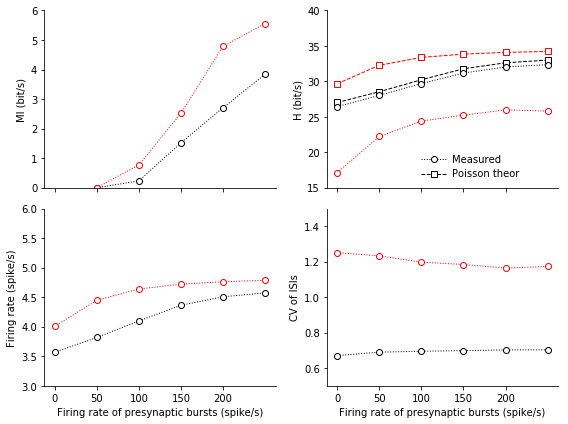

In [10]:
ms = 6
cmap = {'Thorny': 'k', 'A-thorny': 'r'}
fig,ax = plt.subplots(2, 2, figsize=(8,6), sharex=True)
for cell_type in cell_types:
    ax[0,0].plot(poisson_rate[cell_type], MI[cell_type], 'o:', color=cmap[cell_type], 
               markerfacecolor='w', markersize=ms, lw=1, markeredgewidth=1)
    ax[0,1].plot(poisson_rate[cell_type], Hx_theor[cell_type], 's--', color=cmap[cell_type], 
               markerfacecolor='w', markersize=ms, lw=1, markeredgewidth=1)
    ax[0,1].plot(poisson_rate[cell_type], Hx[cell_type], 'o:', color=cmap[cell_type],
               markerfacecolor='w', markersize=ms, lw=1, markeredgewidth=1)
    ax[1,0].plot(poisson_rate[cell_type], firing_rate[cell_type], 'o:', color=cmap[cell_type],
               markerfacecolor='w', markersize=ms, lw=1, markeredgewidth=1)
    ax[1,1].plot(poisson_rate[cell_type], CV[cell_type], 'o:', color=cmap[cell_type],
               markerfacecolor='w', markersize=ms, lw=1, markeredgewidth=1)

x0 = 100
dx = 30
y0 = 19
dy = -2
ls = [':','--']
lbl = ['Measured', 'Poisson theor']
marker = 'os'
for i in range(2):
    ax[0,1].plot(x0 + np.array([0,dx]), y0 + i*dy + np.zeros(2), 'k' + ls[i], lw=1)
    ax[0,1].plot(x0 + dx/2, y0 + i*dy, 'k' + marker[i], markerfacecolor='w', markersize=ms, lw=1, markeredgewidth=1)
    ax[0,1].text(x0 + 1.2*dx, y0 + i*dy, lbl[i], verticalalignment='center')

for i in range(2):
    for a in ax[i]:
        despine(a)
        if i == 1:
            a.set_xlabel('Firing rate of presynaptic bursts (spike/s)')
            a.set_xticks(np.r_[0:210:50])
ax[0,0].set_ylabel('MI (bit/s)')
ax[0,0].set_ylim([0,6])
ax[0,1].set_ylabel('H (bit/s)')
ax[0,1].set_ylim([15,40])
ax[1,0].set_ylabel('Firing rate (spike/s)')
ax[1,0].set_ylim([3,6])
ax[1,1].set_ylabel('CV of ISIs')
ax[1,1].set_ylim([0.5,1.5])
fig.tight_layout()
fig.savefig(f'synaptic_cooperativity_bin={BIN_SIZE*1e3:.0f}_ms.pdf')

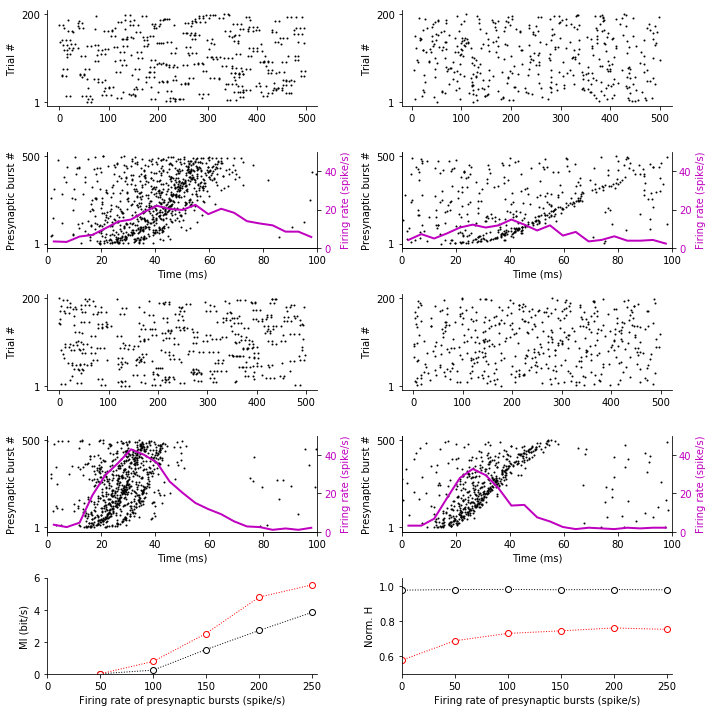

In [48]:
xls_filename = 'mutual_information_synaptic_inputs.xlsx'
with pd.ExcelWriter(xls_filename) as writer:
    data = {'poisson_rate': poisson_rate['Thorny']}
    for k,mi in MI.items():
        data['MI_' + k.lower()] = mi
        data['entropy_' + k.lower()] = Hx[k]
        data['normalized_entropy_' + k.lower()] = Hx[k] / Hx_theor[k]
        data['poisson_entropy_' + k.lower()] = Hx_theor[k]
    df = pd.DataFrame(data)
    df.to_excel(writer, sheet_name='MI_and_entropy')

burst_frequencies = [0, 50, 100, 150, 200, 250]

fig,ax = plt.subplots(5, 2, figsize=(10,10))

for i,cell_type in enumerate(cell_types):
    for j,F in enumerate([100, 200]):
        expt_folder = expt_folders[cell_type] + f'N={N_spines}/F={F}'
        data_file = glob.glob(expt_folder + '/*.npz')[0]
        idx = burst_frequencies.index(F)
        spks, spks_aligned, frate = plot_data_file(data_file,
                                                   ttran,
                                                   firing_rate[cell_type][idx],
                                                   CV[cell_type][idx],
                                                   Hx[cell_type][idx],
                                                   MI[cell_type][idx],
                                                   ax[2*j : 2*(j+1), 1-i])
        df1 = pd.DataFrame({i: pd.Series(spks[i]) for i in range(len(spks))}).T
        df2 = pd.DataFrame({i: pd.Series(spks_aligned[i]) for i in range(len(spks_aligned))}).T
        df3 = pd.DataFrame({'Time': frate[0], 'Rate': frate[1]})
        with pd.ExcelWriter(xls_filename, mode='a') as writer:
            df1.to_excel(writer, sheet_name=f'Spikes_{cell_type}_{F:.0f}_Hz')
            df2.to_excel(writer, sheet_name=f'Spikes_aligned_{cell_type}_{F:.0f}_Hz')
            df3.to_excel(writer, sheet_name=f'Firing_rate_{cell_type}_{F:.0f}_Hz')
    ax[-1,0].plot(poisson_rate[cell_type], MI[cell_type], 'o:', color=cmap[cell_type], 
               markerfacecolor='w', markersize=ms, lw=1, markeredgewidth=1)
    ax[-1,1].plot(poisson_rate[cell_type], Hx[cell_type] / Hx_theor[cell_type], 'o:', color=cmap[cell_type],
               markerfacecolor='w', markersize=ms, lw=1, markeredgewidth=1)

for i in range(2):
    for a in ax[-1,:]:
        despine(a)
        if i == 1:
            a.set_xlabel('Firing rate of presynaptic bursts (spike/s)')
            a.set_xticks(np.r_[0:210:50])

ax[-1,0].set_ylabel('MI (bit/s)')
ax[-1,0].set_xlim([0,255])
ax[-1,0].set_ylim([0,6])
ax[-1,0].set_xticks(np.arange(0,260,50))

ax[-1,1].set_ylabel('Norm. H')
ax[-1,1].set_xlim([0,255])
ax[-1,1].set_ylim([0.5, 1.05])
ax[-1,1].set_xticks(np.arange(0,260,50))

fig.tight_layout()
plt.savefig(os.path.splitext(xls_filename)[0] + '.pdf')